# 偉裕生技 銀耳專案

In [1]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

rootpath = '/media/share/data/Tremella_fuciformis/'

# Data cleaning

In [2]:
def label_cleaning(root_path):
    
    import os
    import numpy as np
    import pandas as pd
    import fnmatch

    dirname = os.listdir(rootpath)

    filename = []

    for pname, dname, fname in os.walk(rootpath):
        files = fnmatch.filter(fname, '*.xlsx')
        filename.append(files)

    filename = list(filter(None, filename))
    
    dirname.remove('T8-170804')
    dirname.remove('T8_train.csv')

    df_all = pd.DataFrame([])
    for name in dirname:
        subdirpath = os.path.join(rootpath, name)
        csvname = fnmatch.filter(os.listdir(subdirpath), '*.xlsx')
        df0 = pd.read_excel(os.path.join(subdirpath, csvname[0]), header=1)
        
        df0_temp = pd.concat([df0['號碼.1'], df0['採收重量'], df0['Unnamed: 28'], df0['新品種']], 1)
        df0_temp = df0_temp.dropna().reset_index(drop=True)
        
        df_sn = pd.DataFrame(np.repeat([name], len(df0_temp)), columns=['sn'])
        df_temp = pd.concat([df_sn, df0_temp], 1)
    
        df_all = pd.concat([df_all, df_temp], 0)

    df_all.columns = ['SN', 'CanSN', 'Weight_mean', 'Weight_std', 'Variety']
    
    return df_all

In [3]:
df = label_cleaning(rootpath)

# replace chinese filename with numbers
df.CanSN = df.CanSN.replace('九', '9')
df.CanSN = df.CanSN.replace('十', '10')
df.CanSN = df.CanSN.replace('十一', '11')
df.CanSN = df.CanSN.replace('6無單', '6')
df_train = df.reset_index(drop=True)
df_train.head(5)

,SN,CanSN,Weight_mean,Weight_std,Variety
0,T8-170705,4,99.000000,11.043303,T1-2
1,T8-170705,6,91.375000,11.445771,T3
2,T8-170705,7,76.208333,12.281654,T8
3,T8-170705,3,63.125000,11.213071,T3
4,T8-170705,4,95.083333,18.537227,T1-2


# EDA

In [ ]:
df.describe()

In [4]:
# stacking
c50p = []
for idx in range(len(df_train)):
    target_v = df['Weight_mean'].iloc[idx]
    if target_v < 60:
        c50p.append('F')
    else:
        c50p.append('C')


df_train['c50p'] = c50p

## ERROR NOTES
- T8-170705, CAN-SN 'S3'不存在影像， 排出此資料
- T8-170804, 影像資料編號與檔案編號對不起來,排除此資料夾

In [5]:
df_train = df_train.drop([7], 0).reset_index(drop=True)

In [ ]:
df_train.to_csv(rootpath+'T8_train.csv')

In [3]:
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le = LabelEncoder().fit(['C', 'F'])

def img_gen(indexlist):
    img_file = []
    label = []
    for idx in indexlist:
        subpath = os.path.join(rootpath, df_train['SN'][idx])
        target = str(df_train['CanSN'][idx]).split('.')[0]
        img = plt.imread(subpath + '/image_' + target +'.jpg')
        if img.shape[0] > img.shape[1]:
            img = np.transpose(img, (1, 0, 2))

        img_file.append(resize(img, (256, 256, 3), mode='reflect'))
        label.append(df_train['c50p'][idx])
    
    img_demean = np.array(img_file) - np.mean(img_file)
    labels = to_categorical(le.transform(label), num_classes=2)
    return np.array(img_file), labels

In [ ]:
 df_train

# image preprocess

In [ ]:
def define_roi(file):
    
    from skimage.color import rgb2gray
    from skimage.feature import canny
    from skimage.segmentation import clear_border
    from skimage.morphology import disk, closing, remove_small_objects, opening
    from skimage.filters import rank, sobel, threshold_otsu, threshold_local
    from scipy import ndimage

    img = plt.imread(file)
    if img.shape[0] > img.shape[1]:
        img = np.transpose(img, (1, 0, 2))
    
    # to grayscale
    img_g = rgb2gray(img)

    # find edges
    edges = canny(img_g, sigma=1.0,
                  low_threshold=0.1, 
                  high_threshold=0.5)

    # find rois
    thres_img = threshold_otsu(edges)
    edges_thres = edges > thres_img
    
    edges_thres = ndimage.binary_fill_holes(edges_thres)
    
    mark = sobel(edges_thres)
    mask = np.zeros_like(mark)
    mask[mark < 0] = 0
    mask[mark > 0] = 1
    c_rois = closing(mask, disk(12))
    c_rois = opening(mask, disk(6))
    
    thres_rois = threshold_local(c_rois, block_size=5, method='mean', mode='nearest')
    c_rois[thres_rois >= 1] = 1
    c_rois[thres_rois < 1] = 0

    # mean filter
    roi = rank.mean_bilateral(c_rois, selem=disk(64), s0=256, s1=256)
    mean_filter = roi.mean()
    roi[roi < mean_filter] = 0
    roi[roi >= mean_filter] = 1
    
    return img, roi

# preprocess from YH

In [ ]:
from skimage import morphology
import cv2
def Convert8Bits(image, display_min, display_max): # copied from Bi Rico
    # Here I set copy=True in order to ensure the original image is not
    # modified. If you don't mind modifying the original image, you can
    # set copy=False or skip this step.
    image = np.array(image, copy=True)   
    image.clip(display_min, display_max, out=image)
    image -= display_min
    np.floor_divide(image, (display_max - display_min + 1) / 256,
                    out=image, casting='unsafe')       
    
    return image.astype(np.uint8)


#convert the image to 8-bit format
def MaskGenerator(inputImg):
    
    from skimage.color import rgb2gray
    from skimage.filters import sobel
    inputImg = rgb2gray(inputImg)
    inputImg = sobel(inputImg)
    
    rows, cols = inputImg.shape
    gap = 3
    tmp = Convert8Bits(inputImg, np.min(inputImg), np.max(inputImg))

    # Otsu's thresholding after Gaussian filtering 
    blur = cv2.GaussianBlur(tmp,(7,7),0)  
    ret,tmp_mask = cv2.threshold(blur[gap:rows-1, gap:cols-1],0,255, cv2.THRESH_OTSU)
    mask0 = np.zeros((rows, cols))
    mask0[tmp>ret] = 255          

    kernel = np.ones((11,11),np.uint8)
    mask1 = cv2.morphologyEx(tmp_mask, cv2.MORPH_CLOSE, kernel)
    
    final_mask = np.ones((mask1.shape[0]+2,mask1.shape[1]+2),np.uint8)
    final_mask[:] = 0
    
    flags = 8
    flags |= cv2.FLOODFILL_MASK_ONLY
    cv2.floodFill(mask1.astype(np.uint8), final_mask, (600,300), flags);
    final_mask_inv = cv2.bitwise_not(final_mask[1:mask1.shape[0]+1, 1:mask1.shape[1]+1])
    
    final_mask = cv2.GaussianBlur(final_mask,(59,59),0)
    final_mask[final_mask>60] = 255
            
    return final_mask

## 2.image process

In [ ]:
pdpath = os.listdir(rootpath)
img_df = pd.DataFrame([], columns=['image_array', 'img_path', 'image_name'])

num = 0

for i, pdname in enumerate(pdpath):
    img_name = fnmatch.filter(os.listdir(os.path.join(rootpath, pdname)), '*.jpg')
    
    num = num + len(img_name)
    for j, fname in enumerate(img_name):
        filename = rootpath + pdname + '/' + fname
        
        img = plt.imread(filename)
        roi = MaskGenerator(img)
#         img, roi = define_roi(filename)
        
        plt.figure()
        plt.imshow(roi, alpha=0.8)
        plt.imshow(img, alpha=0.6)
# print('All valid image file numeber :', num)

In [ ]:
pdpath = os.listdir(rootpath)
img_df = pd.DataFrame([], columns=['image_array', 'img_path', 'image_name'])

num = 0

for i, pdname in enumerate(pdpath):
    img_name = fnmatch.filter(os.listdir(os.path.join(rootpath, pdname)), '*.jpg')
    
    num = num + len(img_name)
    for j, fname in enumerate(img_name):
        filename = rootpath + pdname + '/' + fname
        img, roi = define_roi(filename)
        
        plt.figure()
        plt.imshow(roi, alpha=0.8)
        plt.imshow(img, alpha=0.6)
# print('All valid image file numeber :', num)

# Densenet

In [2]:
import keras.backend as K
from keras.applications import densenet
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
import datetime

K.clear_session()
base_model = densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)
model.summary()
model.compile(optimizer=Adam(lr=0.02), loss='categorical_crossentropy', metrics=['accuracy'])

Using TensorFlow backend.


30015488/30011760 [==============================] - 25s 1us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
___________________________________________

# Trainning

In [ ]:
df_train

In [5]:
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input

In [7]:
from sklearn.model_selection import StratifiedKFold
n_flod = 5
df_train = pd.read_csv(rootpath + 'T8_train.csv')
skf = StratifiedKFold(n_flod, shuffle=True, random_state=np.random)
for train_idx, val_idx in skf.split(df_train, df_train['c50p']):
    break
    
print(len(train_idx))

92


In [7]:
train_gen = ImageDataGenerator(rotation_range=45,
                               zoom_range=[0.8, 1.2], 
                               horizontal_flip=True, 
                               vertical_flip=True)

In [26]:
# deamean
images = np.subtract(X_train, np.tile(np.mean(X_train, axis=0), (len(X_train), 1, 1, 1)))

In [14]:
mean_img = np.mean(X_train, axis=0)

3


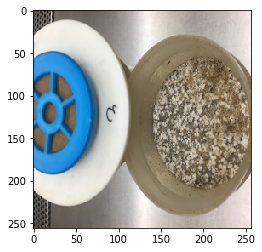

In [10]:
plt.imshow(X_train[1])
print(len(X_train[1].shape))

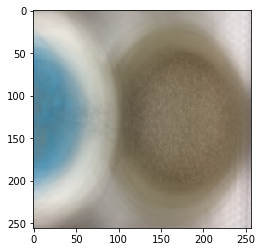

In [15]:
plt.imshow(mean_img)

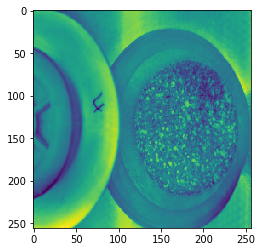

In [39]:
from skimage.color import rgb2gray
plt.imshow(rgb2gray(images[1]))

In [9]:
X_train, y_train = img_gen(train_idx)
X_val, y_val = img_gen(val_idx)

In [51]:
X_train_demean = np.subtract(X_train, np.tile(np.mean(X_train, axis=0), (len(X_train), 1, 1, 1)))
X_val_demean = np.subtract(X_val, np.tile(np.mean(X_val, axis=0), (len(X_val), 1, 1, 1)))

In [8]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(df_train['c50p']), df_train['c50p'])

In [22]:
model_checkpoint = ModelCheckpoint('fungus-preprocess0202-{epoch:02d}-{val_acc:.4f}.hdf5',
                                   monitor='val_acc', save_best_only=True, save_weights_only=True)

# model_earlystop = EarlyStopping(patience=32, monitor='val_acc')

batch_size = 32

train_history = model.fit_generator(train_gen.flow(preprocess_input(X_train), y_train, batch_size), 
                                    epochs=2**6, steps_per_epoch=len(X_train)//2, 
                                    validation_data=train_gen.flow(preprocess_input(X_val), y_val, batch_size), 
                                    validation_steps=len(X_val)//2,
                                    verbose=2, 
                                    callbacks=[model_checkpoint])

Epoch 1/64
 - 75s - loss: 0.8441 - acc: 0.7013 - val_loss: 3.8683 - val_acc: 0.7600
Epoch 2/64
 - 24s - loss: 0.5399 - acc: 0.7840 - val_loss: 3.8683 - val_acc: 0.7600
Epoch 3/64
 - 25s - loss: 0.5335 - acc: 0.7836 - val_loss: 3.8683 - val_acc: 0.7600
Epoch 4/64
 - 25s - loss: 0.5393 - acc: 0.7846 - val_loss: 2.8633 - val_acc: 0.7600
Epoch 5/64
 - 25s - loss: 0.5440 - acc: 0.7796 - val_loss: 3.8683 - val_acc: 0.7600
Epoch 6/64
 - 25s - loss: 0.5316 - acc: 0.7821 - val_loss: 3.8683 - val_acc: 0.7600
Epoch 7/64
 - 25s - loss: 0.5380 - acc: 0.7817 - val_loss: 3.8683 - val_acc: 0.7600
Epoch 8/64
 - 24s - loss: 0.5287 - acc: 0.7833 - val_loss: 1.4571 - val_acc: 0.7600
Epoch 9/64
 - 24s - loss: 0.5293 - acc: 0.7829 - val_loss: 0.6846 - val_acc: 0.7600
Epoch 10/64
 - 25s - loss: 0.5320 - acc: 0.7813 - val_loss: 0.8786 - val_acc: 0.7600
Epoch 11/64
 - 24s - loss: 0.5287 - acc: 0.7843 - val_loss: 3.8683 - val_acc: 0.7600
Epoch 12/64
 - 24s - loss: 0.5359 - acc: 0.7819 - val_loss: 1.4317 - val_a

KeyboardInterrupt: 

# Evaluation

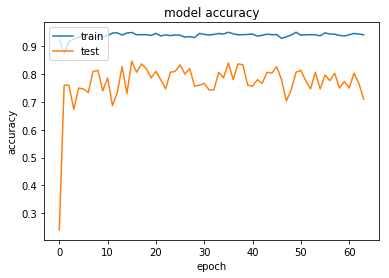

In [54]:
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

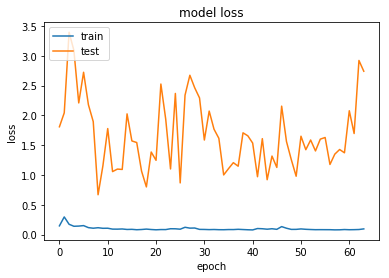

In [55]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
model.load_weights('fungus-test20180201-smcw-16-0.8467.hdf5')
model.evaluate(X_val, y_val)

25/25 [==============================] - 0s 7ms/step


[3.8683428764343262, 0.75999999046325684]

In [57]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_val).argmax(axis=-1)
print(classification_report(y_val.argmax(axis=-1), y_pred, target_names=['A-60', 'B-60']))

             precision    recall  f1-score   support

       A-60       0.76      1.00      0.86        19
       B-60       0.00      0.00      0.00         6

avg / total       0.58      0.76      0.66        25



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
model.save('Tremella_fuciformis.hdf5')

# Prediction

In [ ]:
img = plt.imread('/media/share/data/Tremella_fuciformis/T8-170705/image_5.jpg')
img = resize(img, (256, 256, 3), mode='reflect')
# img = img[np.newaxis, :, :, :]

In [ ]:
y_pred = model.predict(img)

# Testing

In [3]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from skimage.transform import resize
import fnmatch

model = load_model('/media/share/jiaxin_cmu/Tremella_fuciformis_v1/Tremella_fuciformis.hdf5')
testpath = '/media/share/data/Tremella_fuciformis/validation/'
valdir = os.listdir(testpath)

test_img = []

for idx in valdir:
    subpath = os.path.join(testpath, idx)
    subdir = fnmatch.filter(os.listdir(subpath), '*_val')
    for iidx in subdir:
        canpath = os.path.join(subpath, iidx)
        candir = os.listdir(canpath)
        for jdx in candir:
            imgpath = os.path.join(canpath, jdx)
            images = fnmatch.filter(os.listdir(imgpath), '*.JPG')
            SN = idx + '/' + iidx + '/' + jdx
            test_img.append((SN, images))
        
test_df = pd.DataFrame(test_img, columns=['SN', 'image'])

In [4]:
y_pred = []

for idx in range(len(test_df)):
    filepath = os.path.join(testpath, test_df['SN'].iloc[idx])
    for iidx in test_df['image'].iloc[idx]:
        img = plt.imread(filepath + '/' + iidx)
        if img.shape[0] > img.shape[1]:
            img = np.transpose(img, (1, 0, 2))
        img = resize(img, (256, 256, 3), mode='reflect')
        img = img[np.newaxis, :, :, :]
        y_pred.append((test_df['SN'].iloc[idx], iidx, model.predict(img).argmax(axis=-1)))

In [5]:
prediction = pd.DataFrame(y_pred, columns=['SN', 'canSN', 'Prediction'])
prediction.to_csv(testpath + 'prediction_T8.csv', index=False)

In [109]:
summerys = prediction.groupby('SN')
summerys.sum()
summerys.sum().to_csv(testpath + 'pred_sum.csv')

,Prediction
SN,
171227/171225_val/2,0
171227/171225_val/3,0
171227/171225_val/4,0
171227/171225_val/5,0
171227/171225_val/6,0
171227/171225_val/7,0
171229/171227_val/1,0
171229/171227_val/10,3
171229/171227_val/2,0


In [8]:
results = pd.read_csv('/media/share/data/Tremella_fuciformis/validation/prediction_T8.csv')
results.head()

,SN,canSN,Prediction
0,171227/171225_val/3,7.JPG,[0]
1,171227/171225_val/3,8.JPG,[0]
2,171227/171225_val/3,3.JPG,[0]
3,171227/171225_val/3,1.JPG,[0]
4,171227/171225_val/3,17.JPG,[0]
